Neural Network: Linear Regression
===

**Autor:** Mateus de Jesus Mendes

# Introdução

O presente *Jupyter Notebook* tem por objetivo implementar em Python puro uma Rede Neural Linear de Camada Única Integralmente Conectada para regressão.

# Metodologia

### Importações

In [377]:
import random
import matplotlib.pyplot as plt

### Definições Globais

In [378]:
RANDOM_SEED = 88
random.seed(RANDOM_SEED)

### Funções Auxiliares

Funções secundárias utilizadas nas etapas principais da metodologia. 

##### **Produto Interno**

In [379]:
def dot(a, b):
    """
    Cálculo do produto interno dos casos:
    - Vetor-vetor
    - Matriz-vetor
    - Matriz-matriz
    
    ### Parâmetros
    - `a`/`b`: Vetor ou matriz.

    ### Retorna
    Float (escalar) para produto vetor-vetor / Lista (vetor) para produto matriz-vetor / Matriz (lista de listas) para produto matriz-matriz.
    """

    # Funções auxiliares de identificação
    def is_vector(x):
        return isinstance(x[0], (int, float))

    def is_matrix(x):
        return isinstance(x[0], list)

    # Produto vetor-vetor -> escalar
    if is_vector(a) and is_vector(b):
        if len(a) != len(b):
            raise ValueError("Vetores devem ter o mesmo comprimento.")
        
        s = 0
        for i in range(len(a)):
            s += a[i] * b[i]
        return s

    # Produto matriz-vetor -> vetor
    if is_matrix(a) and is_vector(b):
        n_rows = len(a)
        n_cols = len(a[0])

        if n_cols != len(b):
            raise ValueError("Dimensões incompatíveis para produto matriz-vetor.")

        result = []
        for i in range(n_rows):
            sum = 0
            for j in range(n_cols):
                sum += a[i][j] * b[j]
            result.append(sum)
        return result

    # Produto matriz-matriz -> matriz
    if is_matrix(a) and is_matrix(b):
        n_rows_a = len(a)
        n_cols_a = len(a[0])
        n_rows_b = len(b)
        n_cols_b = len(b[0])

        if n_cols_a != n_rows_b:
            raise ValueError("Dimensões incompatíveis para produto matriz-matriz.")

        result = []
        for i in range(n_rows_a):
            row = []
            for j in range(n_cols_b):
                sum = 0
                for k in range(n_cols_a):
                    sum += a[i][k] * b[k][j]
                row.append(sum)
            result.append(row)
        return result

    # Caso inválido
    raise TypeError("Entradas devem ser vetores ou matrizes válidas.")

##### ***Holdout***

In [380]:
def holdout(X, y, train_size=0.8):
    """
    Realiza a partição *holdout* de um conjunto de dados supervisionado
    em subconjuntos de treinamento e teste.

    A função separa aleatoriamente o conjunto de dados original
    D = {(x_i, y_i)}_{i=1}^{N} em dois subconjuntos disjuntos:
    um conjunto de treinamento D_train e um conjunto de teste D_test,
    respeitando a proporção especificada por `train_size`.

    ### Parâmetros
    - `X` (list[list[float]]): Conjunto de N vetores de entrada, X = {x₁, x₂, …, x_N}, com x_i ∈ ℝᵈ.

    - `y` (list[float]): Vetor dos valores alvo associados às instâncias de entrada, y = (y₁, y₂, …, y_N).

    - `train_size` (float, opcional): Fração do conjunto de dados destinada ao treinamento, com 0 < `train_size` < 1.

    ### Retorno
    tuple[list, list, list, list]

        Tupla `(X_train, X_test, y_train, y_test)`, onde:
     - `X_train`: subconjunto dos vetores de entrada utilizados no treinamento;
     - `X_test`: subconjunto dos vetores de entrada utilizados na avaliação;
     - `y_train`: valores alvo correspondentes ao conjunto de treinamento;
     - `y_test`: valores alvo correspondentes ao conjunto de teste.

    ### Observações
    - A partição é realizada por embaralhamento aleatório dos índices,
      caracterizando um *holdout* simples.
    - Não há estratificação em relação à variável alvo.
    - Não há controle explícito de *seed*, o que implica não reprodutibilidade
      entre execuções distintas.
    - A função preserva a correspondência entre instâncias de entrada e seus
      respectivos valores alvo.
    """


    if not 0 < train_size < 1:
        raise ValueError('train_size deve estar no intervalo (0, 1).')
    
    if len(X) != len(y):
        raise ValueError('X e y devem ter o mesmo comprimento.')

    n = len(X)
    indices = list(range(n))
    random.shuffle(indices)

    split = int(n * train_size)

    train_idx = indices[:split]
    test_idx = indices[split:]

    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]

    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]

    return X_train, X_test, y_train, y_test

### 0. Geração / Leitura de Dados

O conjunto de dados é gerado a partir do modelo linear com ruído aditivo:
$$
y_i = \mathbf{w}_{\text{true}}^{\top}\mathbf{x}_i + b_{\text{true}} + \varepsilon_i,
\quad i = 1, \dots, N
$$

Em que:
- $\mathbf{x}_i \in \mathbb{R}^d$ é o vetor de *features* da $i$-ésima amostra;
- $\mathbf{w}_{\text{true}} \in \mathbb{R}^d$ é o vetor de pesos verdadeiro;
- $b_{\text{true}} \in \mathbb{R}$ é o viés verdadeiro;
- $\varepsilon_i \sim \mathcal{N}(0, 1)$ representa ruído Gaussiano aditivo independente.

Os vetores $\mathbf{x}_i$ também são amostrados de uma Distribuição Normal Padrão:

$$
\mathbf{x}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
$$

In [381]:
def synth_data(n_examples, n_features, return_params=False):
    """
    Gera um conjunto de dados sintético para regressão linear com ruído aditivo.

    A função constrói um *dataset* artificial a partir do modelo gerador

        y_i = w_trueᵀ x_i + b_true + ε_i,

    onde x_i ∈ ℝᵈ são vetores de entrada amostrados de uma distribuição Gaussiana,
    w_true ∈ ℝᵈ é o vetor de pesos verdadeiro, b_true ∈ ℝ é o viés verdadeiro
    e ε_i ∈ ℝ representa ruído aditivo Gaussiano independente.

    ### Parâmetros
    - `n_examples` (int): Número de instâncias (amostras) a serem geradas, N.

    - `n_features` (int): Dimensionalidade do espaço de entrada, d, correspondente ao número de *features* de cada vetor x_i ∈ ℝᵈ.

    - `return_params` (bool, opcional): Se verdadeiro, a função retorna também os parâmetros fundamentais utilizados no processo gerador
    dos dados (`w_true`, `b_true`).

    ### Retorno
    tuple

    - Se `return_params=False`, retorna a tupla `(X, y)`, onde:
        - `X` ∈ ℝ^{N×d} é a coleção de vetores de entrada;
        - `y` ∈ ℝ^{N} é o vetor de valores alvo gerados.

    - Se `return_params=True`, retorna a tupla `(X, y, w_true, b_true)`, contendo adicionalmente:
        - `w_true` ∈ ℝᵈ, vetor de pesos verdadeiro;
        - `b_true` ∈ ℝ, viés verdadeiro.

    ### Observações
    - Os vetores de entrada `x_i` e o ruído ε_i são amostrados de distribuições
      Gaussianas independentes com média zero e variância unitária.
    - O viés verdadeiro `b_true` é fixado como uma constante escalar.
    - A função pressupõe a existência de rotinas externas para amostragem
      Gaussiana (`sample_gaussian`) e cálculo de produto interno (`dot`).
    - Não há controle explícito de *seed*, o que implica não reprodutibilidade
      entre execuções distintas.
    """

    X = [] # Matriz de instâncias e features
    y = [] # Vetor de targets

    # Vetor verdadeiro de pesos
    w_true = [random.gauss() for _ in range(n_features)]

    # Viés verdadeiro
    b_true = 8.0

    for _ in range(n_examples):
        x_i = [random.gauss() for _ in range(n_features)]

        noise = random.gauss()

        y_i = dot(w_true, x_i) + b_true + noise

        X.append(x_i)
        y.append(y_i)

    if return_params:
        return X, y, w_true, b_true
    else:
        return X, y


### 1. Definição do Modelo

O modelo considerado corresponde a uma transformação afim totalmente conectada, definida por:
$$
\hat{y} = \mathbf{w}^{\top}\mathbf{x} + b
$$

Em que:
- $\mathbf{x} \in \mathbb{R}^d$ é o vetor de entrada;
- $\mathbf{w} \in \mathbb{R}^d$ é o vetor de pesos treináveis;
- $b \in \mathbb{R}$ é o termo de viés.

Os parâmetros $\mathbf{w}$ e $b$ são inicializados aleatoriamente a partir de uma distribuição uniforme simétrica de pequeno suporte em torno de zero:
$$
w_j \sim \mathcal{U}(-\epsilon, \epsilon),
\quad
b \sim \mathcal{U}(-\epsilon, \epsilon),
\quad
\epsilon = 10^{-3}
$$

Essa abordatem tem por objetivo garantir estabilidade numérica e dinâmica adequada do gradiente nas etapas iniciais do treinamento.

In [382]:
def model(n_features):
    """
    Inicializa os parâmetros treináveis de um modelo linear (camada totalmente conectada).

    A função constrói os parâmetros de uma transformação afim definida por

        ŷ = wᵀ x + b,

    onde w ∈ ℝᵈ é o vetor de pesos e b ∈ ℝ é o termo de viés. Os parâmetros são
    inicializados com valores aleatórios de pequena magnitude, centrados em zero,
    de modo a favorecer estabilidade numérica durante as primeiras etapas do
    treinamento baseado em gradiente.

    ### Parâmetros
    - `n_features` (int): Dimensionalidade do espaço de entrada (d), correspondente ao número de *features* de cada vetor x ∈ ℝᵈ.

    ### Retorno
    tuple[list[float], float]

        Tupla `(w, b)` contendo:

    - `w`: vetor de pesos inicializado aleatoriamente, w ∈ ℝᵈ;
    - `b`: escalar correspondente ao viés do modelo.

    ### Observações
    - A inicialização utiliza uma distribuição uniforme simétrica em torno de zero
      com suporte reduzido, o que é consistente com práticas básicas de inicialização
      para modelos lineares.
    - A função não depende da distribuição dos dados nem do tamanho do *batch*.
    - Não há controle explícito de *seed* para reprodutibilidade.
    """

    # Inicializa o vetor de pesos com valores centrados em 0
    w = [random.uniform(-1e-3, 1e-3) for _ in range(n_features)]

    # Inicializa o viés com valor centrado em 0
    b = random.uniform(-1e-3, 1e-3)

    return w, b

### 2. *Forward Pass*

Dado um conjunto de $N$ vetores de entrada, o *forward pass* do modelo linear consiste na aplicação de uma transformação afim independente a cada instância:
$$
\hat{y}_i = \mathbf{w}^{\top}\mathbf{x}_i + b
\quad i = 1,\dots,N
$$

Em forma vetorial:
$$
\hat{\mathbf{y}} = \mathbf{X}\mathrm{w} + b
$$

Em que:
- $X \in \mathbb{R}^{N \times d}$ é a matriz de entradas;
- $\mathbf{w} \in \mathbb{R}^{d}$ é o vetor de pesos do modelo;
- $b \in \mathbb{R}$ é o termo de viés;
- $\hat{\mathbf{y}} \in \mathbb{R}^{N}$ é o vetor de saídas pré-ativação (*logits*).

Cada saída $\hat{y}_i$ corresponde à predição linear do modelo para a $i$-ésima amostra, sem aplicação de função de ativação não linear.

**Observações conceituais**
- Este *forward pass* implementa exatamente uma camada totalmente conectada linear, sendo matematicamente equivalente à regressão linear multivariada.
- A ausência de função de ativação implica que o espaço de hipóteses do modelo é estritamente afim.
- A independência entre as amostras reflete-se na forma escalar da operação aplicada a cada $\mathbf{x}_i$.

In [383]:
def forward(X, w, b):
    """
    Executa o *forward pass* de um modelo linear (camada totalmente conectada sem função de ativação).

    Dado um conjunto de vetores de entrada, a função aplica uma transformação afim da forma

        ŷ_i = wᵀ x_i + b,

    onde x_i ∈ ℝᵈ representa a i-ésima instância de entrada, w ∈ ℝᵈ é o vetor de pesos
    treináveis do modelo e b ∈ ℝ é o termo de viés. O resultado corresponde às saídas
    pré-ativação (*logits*) do modelo.

    ### Parâmetros
    - `X` (list[list[float]]): Coleção de N vetores de entrada, X = {x₁, x₂, …, x_N}, com x_i ∈ ℝᵈ. Cada sublista representa uma instância 
    e deve possuir a mesma dimensionalidade do vetor de pesos `w`.

    - `w` (list[float]): Vetor de pesos do modelo linear, w ∈ ℝᵈ.

    - `b` (float): Escalar correspondente ao termo de viés (*bias*).

    ### Retorno
    list[float]

        Vetor de saídas do modelo, contendo os valores pré-ativação (*logits*)
        associados a cada instância de entrada, na mesma ordem em que aparecem em `X`.

    ### Observações
    - A função implementa uma única camada linear (*fully connected layer*)
      sem função de ativação.
    - Não há verificação explícita de compatibilidade dimensional entre `X` e `w`.
    - A operação de produto interno é realizada por meio da função externa `dot`.
    """

    y_pred = []

    for x_i in X:
        y_pred.append(dot(w, x_i) + b)
    
    return y_pred

### 3. *Loss Function*

A verossimilhança das predições do modelo é avaliada por meio do Erro Quadrático Médio (*Mean Squared Error – MSE*), definido como:

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N}  \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Em que:
- $\mathbf{y} \in \mathbb{R}^{N}$ é o vetor de valores verdadeiros (*targets*);
- $\hat{\mathbf{y}} \in \mathbb{R}^{N}$ é o vetor de predições do modelo;
- $N$ é o número total de amostras.

O MSE penaliza erros grandes de forma quadrática, tornando-se particularmente sensível a desvios significativos entre predição e valor real.


**Observações Conceituais**
- A função de perda é convexa em relação a $\hat{\mathbf{y}}$ e, por composição, em relação aos parâmetros $\mathbf{w}$ e $b$ de modelos lineares.
- É diferenciável em todo o domínio, o que a torna apropriada para métodos de otimização baseados em gradiente.
- Para Ruído Gaussiano Aditivo, a minimização do MSE equivale à estimação de máxima verossimilhança dos parâmetros do modelo.

In [384]:
def mse(y_true, y_pred):
    """
    Calcula a função de perda Erro Quadrático Médio (*Mean Squared Error – MSE*).

    Dado um conjunto de valores verdadeiros e suas respectivas predições, a função
    computa a perda definida por

        L(y, ŷ) = (1 / N) ∑_{i=1}^{N} (y_i − ŷ_i)²,

    onde y_i ∈ ℝ representa o valor alvo (*ground truth*), ŷ_i ∈ ℝ a predição do modelo
    e N o número total de amostras. O MSE corresponde à média empírica do erro quadrático.

    ### Parâmetros
    - `y_true` (list[float]):
        Vetor contendo os valores alvo verdadeiros, y = (y₁, y₂, …, y_N).

    - `y_pred` (list[float]):
        Vetor contendo as predições do modelo, ŷ = (ŷ₁, ŷ₂, …, ŷ_N).

    ### Retorno
    float

        Valor escalar correspondente à perda MSE computada sobre todo o conjunto
        de amostras.

    ### Observações
    - Assume-se correspondência um-para-um entre `y_true` e `y_pred`.
    - A função retorna a perda média, e não a soma dos erros quadráticos.
    - Não há normalização adicional nem ponderação por amostra.
    - A função é diferenciável em relação a `y_pred`, o que a torna adequada
      para otimização baseada em gradiente.
    """
    
    # Assegura dimensionalidade equivalente entre y_true e y_pred 
    assert len(y_true) == len(y_pred)

    total_err = 0
    N = len(y_true)

    for i in range(N):
        total_err += (y_true[i] - y_pred[i])**2
    
    loss = total_err / N

    return loss

### 4. *Backward Pass*

O *backward pass* do modelo linear consiste na avaliação explícita dos gradientes da função de perda em relação aos parâmetros treináveis. 

Considerando o modelo:

$$
\hat{y}_i = \mathbf{w}^{\top}\mathbf{x}_i + b
$$

E a função de perda Erro Quadrático Médio:

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Os gradientes analíticos são dados por:

$$
\nabla_{\mathbf{w}} \mathcal{L} = \frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i),\mathbf{x}_i, \qquad \frac{\partial \mathcal{L}}{\partial b} = 
\frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i).
$$

Essas expressões resultam diretamente da aplicação da regra da cadeia e constituem a base para métodos de otimização por gradiente descendente.

**Observações Conceituais**
- Cada termo $(\hat{y}_i - y_i)$ representa o erro de predição da $i$-ésima amostra.
- O gradiente em relação aos pesos é uma soma ponderada dos vetores de entrada, escalada pelo erro.
- O gradiente em relação ao viés corresponde à média dos erros, refletindo um deslocamento global da função afim.
- A normalização por $N$ garante que a magnitude do gradiente seja independente do tamanho do conjunto de dados.

In [385]:
def backward(X, y_true, y_pred):
    """
    Computa o *backward pass* de um modelo linear, avaliando analiticamente
    os gradientes da função de perda MSE em relação aos parâmetros do modelo.

    Considerando um modelo linear da forma

        ŷ_i = wᵀ x_i + b,

    e a função de perda Erro Quadrático Médio

        L = (1 / N) ∑_{i=1}^{N} (y_i − ŷ_i)²,

    a função calcula os gradientes

     ∂L/∂w = (2 / N) ∑_{i=1}^{N} (ŷ_i − y_i) x_i
        
     ∂L/∂b = (2 / N) ∑_{i=1}^{N} (ŷ_i − y_i),

    os quais podem ser utilizados em um passo subsequente de atualização
    dos parâmetros via métodos de otimização baseados em gradiente.

    ### Parâmetros
    - `X` (list[list[float]]): Conjunto de N vetores de entrada, X = {x₁, x₂, …, x_N}, com x_i ∈ ℝᵈ.

    - `y_true` (list[float]): Vetor dos valores alvo verdadeiros, y = (y₁, y₂, …, y_N).

    - `y_pred` (list[float]): Vetor das predições do modelo, ŷ = (ŷ₁, ŷ₂, …, ŷ_N), obtidas no *forward pass*.

    ### Retorno
    tuple[list[float], float]

        Tupla `(grad_w, grad_b)` contendo:

    - `grad_w`: Vetor dos gradientes da perda em relação aos pesos, ∂L/∂w ∈ ℝᵈ;

    - `grad_b`: Escalar correspondente ao gradiente da perda em relação ao viés, ∂L/∂b ∈ ℝ.

    ### Observações
    - Os gradientes são calculados de forma explícita (analítica), sem o uso
      de diferenciação automática.
    - Assume-se correspondência dimensional entre `X`, `w` e `y_pred`.
    - A função não realiza a atualização dos parâmetros, apenas computa os gradientes.
    - O fator de normalização 1/N está embutido no cálculo final dos gradientes.
    """

    N = len(X)
    d = len(X[0])

    grad_w = [0.0 for _ in range(d)]
    grad_b = 0.0

    for i in range(N):
        error = y_true[i] - y_pred[i]

        for j in range(d):
            grad_w[j] += -2 * error * X[i][j]

        grad_b += -2 * error

    grad_w = [grad_w[k] / N for k in range(d)]
    grad_b /= N

    return grad_w, grad_b

### 5. *Gradient Descent*

A etapa de otimização do modelo é realizada por meio do Gradiente Descendente, que atualiza iterativamente os parâmetros treináveis na direção oposta ao gradiente da função de perda. Para um modelo linear, a regra de atualização é dada por:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta , \nabla_{\mathbf{w}} \mathcal{L}, \qquad b^{(t+1)} = b^{(t)} - \eta , \frac{\partial \mathcal{L}}{\partial b}
$$

Em que:
- $\eta > 0$ é a taxa de aprendizado (*learning rate*);
- $\nabla_{\mathbf{w}} \mathcal{L}$ e $\frac{\partial \mathcal{L}}{\partial b}$ são os gradientes computados no *backward pass*;
- $t$ denota a iteração de treinamento.

Essa atualização corresponde a um único passo de descida no espaço de parâmetros, com o objetivo de minimizar a função de perda.

**Observações Conceituais**
- O Gradiente Descendente explora o fato de que, em modelos lineares com MSE, a função de perda é convexa, assegurando convergência ao mínimo global sob escolha adequada de $\eta$.
- A magnitude da taxa de aprendizado controla o compromisso entre velocidade de convergência e estabilidade numérica.
- A ausência de *momentum* ou mecanismos adaptativos torna essa implementação conceitualmente transparente e didaticamente valiosa.

In [386]:
def gradient_descent(w, b, grad_w, grad_b, lr):
    """
    Atualiza os parâmetros de um modelo linear por meio do método de
    Gradiente Descendente (*Gradient Descent*).

    Dado um conjunto de parâmetros treináveis e seus respectivos gradientes
    em relação a uma função de perda L, a função executa a atualização explícita

     w ← w − η ∂L/∂w

     b ← b − η ∂L/∂b,

    onde η > 0 denota a taxa de aprendizado (*learning rate*). Essa etapa
    corresponde ao passo de otimização subsequente ao *backward pass*.

    ### Parâmetros
    - `w` (list[float]): Vetor de pesos do modelo, w ∈ ℝᵈ.

    - `b` (float): Escalar correspondente ao termo de viés do modelo.

    - `grad_w` (list[float]): Vetor dos gradientes da função de perda em relação aos pesos, ∂L/∂w ∈ ℝᵈ.

    - `grad_b` (float): Gradiente da função de perda em relação ao viés, ∂L/∂b ∈ ℝ.

    - `lr` (float): Taxa de aprendizado η, que controla o tamanho do passo de atualização no espaço de parâmetros.

    ### Retorno
    tuple[list[float], float]

        Tupla `(w, b)` contendo os parâmetros atualizados após um passo de aplcação do Gradiente Descendente.

    ### Observações
    - A atualização é realizada *in-place* para o vetor de pesos `w`.
    - A função implementa Gradiente Descendente em sua forma mais simples,
      sem *momentum*, regularização ou adaptação da taxa de aprendizado.
    - Assume-se compatibilidade dimensional entre `w` e `grad_w`.
    """

    for i in range(len(grad_w)):
      w[i] = w[i] - lr * grad_w[i]
        
    b = b - lr * grad_b

    return w, b

### 6. *Training Loop*

O treinamento do modelo é realizado por meio de um *loop* iterativo de otimização baseada em gradiente, no qual os parâmetros do modelo são ajustados progressivamente para minimizar a função de perda Erro Quadrático Médio (MSE):
$$
\mathcal{L}(\mathbf{w}, b) = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - (\mathbf{w}^{\top}\mathbf{x}_i + b)\right)^2.
$$

A cada época, o seguinte ciclo é executado:

1. Inicialização dos parâmetros $(\mathbf{w}, b)$ (realizada uma única vez);
2. *Forward pass* para obtenção das predições $\hat{\mathbf{y}}$;
3. Avaliação da perda $\mathcal{L}$;
4. *Backward pass* para cálculo analítico dos gradientes;
5. Atualização dos parâmetros via Gradiente Descendente.

De forma abstrata, o processo pode ser descrito como:

$$
(\mathbf{w}, b) \xleftarrow{\text{iterativamente}} \arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b), \quad \text{via Gradiente Descendente em modo batch}.
$$

O vetor `loss_log` armazena o valor da função de perda ao final de cada época, permitindo a análise da dinâmica de convergência do treinamento.

**Observações conceituais**
- O treinamento é realizado em modo *batch*, utilizando todo o conjunto de dados em cada iteração.
- Em modelos lineares com MSE, a função objetivo é convexa, garantindo convergência ao mínimo global sob escolha adequada da taxa de aprendizado.
- A ausência de *early stopping*, regularização ou validação torna o procedimento conceitualmente simples e transparente, favorecendo análise didática do comportamento do gradiente.

In [387]:
def train(X, y, epochs, lr):
    """
    Executa o procedimento de treinamento de um modelo linear por otimização iterativa baseada em gradiente.

    A função implementa um *training loop* completo, composto pelas etapas
    de inicialização dos parâmetros, *forward pass*, avaliação da função de
    perda Erro Quadrático Médio (MSE), *backward pass* para cálculo dos gradientes
    e atualização dos parâmetros via Gradiente Descendente.

    Em cada época, o modelo ajusta seus parâmetros `(w, b)` de modo a minimizar
    a função objetivo

        L(w, b) = (1 / N) ∑_{i=1}^{N} (y_i − (wᵀ x_i + b))².

    ### Parâmetros
    - `X` (list[list[float]]): Conjunto de N vetores de entrada, X = {x₁, x₂, …, x_N}, com x_i ∈ ℝᵈ.

    - `y` (list[float]): Vetor dos valores alvo associados às instâncias de entrada, y = (y₁, y₂, …, y_N).

    - `epochs` (int): Número de iterações completas sobre o conjunto de dados (épocas de treinamento).

    - `lr` (float): Taxa de aprendizado utilizada no método de Gradiente Descendente.

    ### Retorno
    tuple

     Tupla `(w, b, loss_log)` contendo:
     - `w` (list): Vetor contendo os pesos finais estimados.
     - `b` (float): Escalar representando o viés final estimado.
     - `loss_log` (list): Registro da perda do modelo ao fim de cada época de treino.
  

    ### Observações
    - O treinamento é realizado em modo *batch*, utilizando todo o conjunto
      de dados a cada época.
    - Os parâmetros do modelo são inicializados uma única vez, antes do início
      do loop de treinamento.
    - A função não retorna os parâmetros finais `(w, b)`; apenas o histórico
      da perda pode ser recuperado opcionalmente.
    - Não há critérios de parada antecipada (*early stopping*), validação
      ou regularização.
    """

    loss = 0.0
    loss_log = []

    n_features = len(X[0])
    w, b = model(n_features)

    for epoch in range(epochs):
        y_pred = forward(X, w, b)
        loss = mse(y, y_pred)
        loss_log.append(loss)
        grad_w, grad_b = backward(X, y, y_pred)
        w, b = gradient_descent(w, b, grad_w, grad_b, lr)

    return w, b, loss_log

# Teste

In [388]:
# Geração de dados sintéticos
n_examples, n_features = (1_000, 5)
X, y, w_true, b_true = synth_data(n_examples, n_features, return_params=True)

# Treino do modelo
w, b, loss_log = train(X, y, epochs=10_000, lr=0.001)

print(f'Loss (MSE) final do modelo: {loss_log[-1]}')

Loss (MSE) final do modelo: 0.9828628897967788


# Resultados

Comparação entre os parâmetros fundamentalmente verdadeiros definidos na geração dos dados sintéticos e os parâmetros estimados pelo modelo:

In [389]:
print("Parâmetros verdadeiros:")
print("w_true =", w_true)
print("b_true =", b_true)

print("\nParâmetros aprendidos:")
print("w_hat  =", w)
print("b_hat  =", b)

Parâmetros verdadeiros:
w_true = [-0.5183735347655064, 0.3892625131435465, 1.1464241141605414, -0.8063735255551222, -1.5231055130747249]
b_true = 8.0

Parâmetros aprendidos:
w_hat  = [-0.5130019754214008, 0.3701679696990196, 1.1335186935614157, -0.8121331362295992, -1.529172872508083]
b_hat  = 7.96790247576778


Visualização da evolução da *loss* do modelo ao longo das épocas de treino:

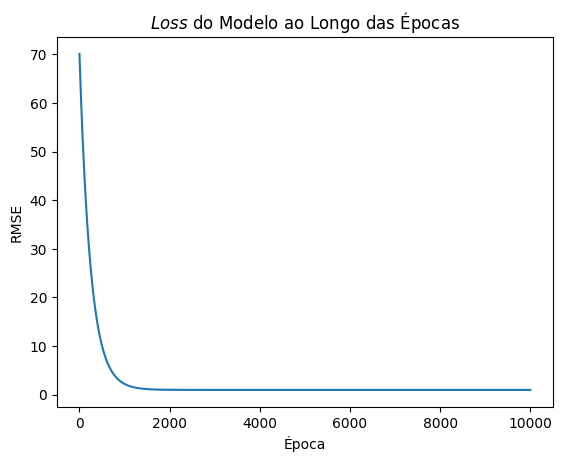

In [390]:
fig, ax = plt.subplots()

ax.plot(loss_log)

ax.set_title('$Loss$ do Modelo ao Longo das Épocas')
ax.set_ylabel('RMSE')
ax.set_xlabel('Época');

# Conclusão

Os resultados obtidos para a Rede Neural Regressora Linear de Camada Única Integralmente Conectada, implementada integralmente em Python puro, evidenciam convergência adequada, estabilidade numérica e consistência teórico-matemática do modelo e do procedimento de treinamento adotado.

Do ponto de vista estrutural, o modelo em análise corresponde a uma rede neural linear do tipo *single-layer fully connected*, cuja função hipótese pode ser expressa como:

$$
\hat{y}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b
$$

Portanto, sendo matematicamente equivalente ao modelo clássico de regressão linear multivariada. Nessa configuração, a superfície de erro associada é a função de perda quadrática média (MSE):

$$
\mathcal{L}(\mathbf{w}, b) = \frac{1}{N}\sum_{i=1}^N \left(y_i - (\mathbf{w}^\top \mathbf{x}_i + b)\right)^2
$$

Isso assegura convexidade, garantindo a existência de um único mínimo global. Assim, sob condições adequadas de taxa de aprendizado e inicialização, o gradiente descendente deve convergir para a solução ótima — fato corroborado empiricamente pelos resultados apresentados.

**Análise da convergência do treinamento**

A curva de *loss* ao longo das épocas revela um comportamento típico de sistemas convexos bem condicionados: uma queda acentuada nas iterações iniciais, seguida por uma região de saturação assintótica, na qual o erro se estabiliza próximo ao mínimo global. A ausência de oscilações ou instabilidades indica que:
- O cálculo analítico dos gradientes está correto;
- A taxa de aprendizado encontra-se em regime estável;
- Não há problemas de explosão ou desaparecimento do gradiente, como esperado para modelos lineares rasos.

Esse comportamento reforça a correção tanto da formulação matemática quanto da implementação algorítmica do treinamento.

**Qualidade da estimação paramétrica**

A comparação entre os parâmetros verdadeiros e os parâmetros aprendidos mostra erro relativo baixo, tanto nos pesos quanto no viés:

- Pesos verdadeiros:
  $$
  \mathbf{w}_{\text{true}} = (-1.5231, 1.1464)
  $$

- Pesos aprendidos:
  $$
  \mathbf{w}_{\text{hat}} = (-1.5292, 1.1335)
  $$

- Viés verdadeiro:
  $$
  b_{\text{true}} = 8.0
  $$

- Viés aprendido:
  $$
  b_{\text{hat}} \approx 7.967
  $$

As discrepâncias observadas são pequenas e estatisticamente compatíveis com a presença de ruído nos dados e com o fato de o treinamento ser realizado por otimização iterativa, e não por solução analítica fechada (equações normais). Em particular, a proximidade entre $\mathbf{w}_{\text{true}}$ e $\mathbf{w}_{\text{hat}}$ indica que o modelo foi capaz de recuperar corretamente a estrutura linear subjacente ao processo gerador dos dados.

**Interpretação do valor final da perda**

O valor final da função de perda,

$$
\text{MSE} \approx 0.98,
$$

implica um erro quadrático médio da ordem da unidade. Considerando que o modelo é linear e que os dados contêm ruído aditivo, esse valor é coerente com um cenário em que:
- A capacidade do modelo está adequadamente alinhada à complexidade do problema;
- Não há *overfitting*, dado o caráter simples da hipótese;
- O erro residual representa majoritariamente variância irredutível dos dados.

Em termos de *Deep Learning*, isso caracteriza um regime de viés estrutural controlado, com variância limitada, exatamente o comportamento esperado para uma rede linear treinada sob MSE.

**Considerações finais**

Em síntese, os resultados obtidos validam plenamente:

1. a formulação matemática da rede neural linear;
2. a implementação manual do *forward pass*, do *backpropagation* e da atualização dos parâmetros;
3. a escolha da função de perda e do método de otimização.

Além disso, este experimento constitui uma base sólida e conceitualmente correta para extensões futuras, tais como:
- Introdução de camadas ocultas e não linearidades;
- Análise comparativa entre otimização analítica e gradiente descendente;
- Estudo do impacto de regularização $\ell_2$ e $\ell_1$;
- Generalização para problemas de regressão não linear.

Portanto, conclui-se que o modelo não apenas converge corretamente, mas também materializa, de forma didática e rigorosa, a ponte entre regressão linear clássica e redes neurais no contexto moderno de aprendizado profundo.